# 安徽安庆市项目`WRF-CMAQ`模拟分析
## Spatial Distribution : `chem-obs data`

---
*@author: Evan*\
*@date: 2023-05-09*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 读取数据

In [2]:
chemFile=xr.open_dataset('F:/Data/case_anqing/April/April_chem.nc')
metFile=xr.open_dataset('F:/Data/case_anqing/April/April_met.nc')

In [3]:
lat=chemFile.latitude
lon=chemFile.longitude

PM25_L1=np.squeeze(chemFile.PM25.sel(level=1000,method='nearest'))

uw_L1=np.squeeze(metFile.uwind.sel(level=1000,method='nearest'))
vw_L1=np.squeeze(metFile.vwind.sel(level=1000,method='nearest'))


print('lat & lon = ',lat.shape)
print('chem      = ',PM25_L1.shape)

lat & lon =  (138, 135)
chem      =  (720, 138, 135)


In [4]:
# calculate MDA8 O3
avg_L1 = PM25_L1.resample({'time':'D'}).mean(dim='time')

# calculate average uv wind
uuL1 = uw_L1.resample({'time':'D'}).mean(dim='time')
vvL1 = vw_L1.resample({'time':'D'}).mean(dim='time')

In [5]:
# read site lat and lon
sites = pd.read_excel('F:/Data/case_anqing/April/obsdata/安庆市站点坐标.xlsx',header=0,usecols=['站点名称','经度','纬度'])

# read obs ozone concentration
# directory containing the Excel files
dir_path = 'F:/Data/case_anqing/April/obsdata/all/'

# create an empty dataframe to store the data
df = pd.DataFrame()

# loop through each file in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.xlsx'): # make sure it's an Excel file
        # read the Excel file into a dataframe and set the first column as the index
        file_path = os.path.join(dir_path, filename)
        temp_df = pd.read_excel(file_path, index_col=0)
        
        # extract the 'O3' column and add it to the main dataframe
        col_name = os.path.splitext(filename)[0] # use the file name as the column name
        df[col_name] = temp_df['PM2.5']

# calculate observation avg NO2
avg_obs = df.resample('D').mean()
avg_obs.shape

(30, 19)

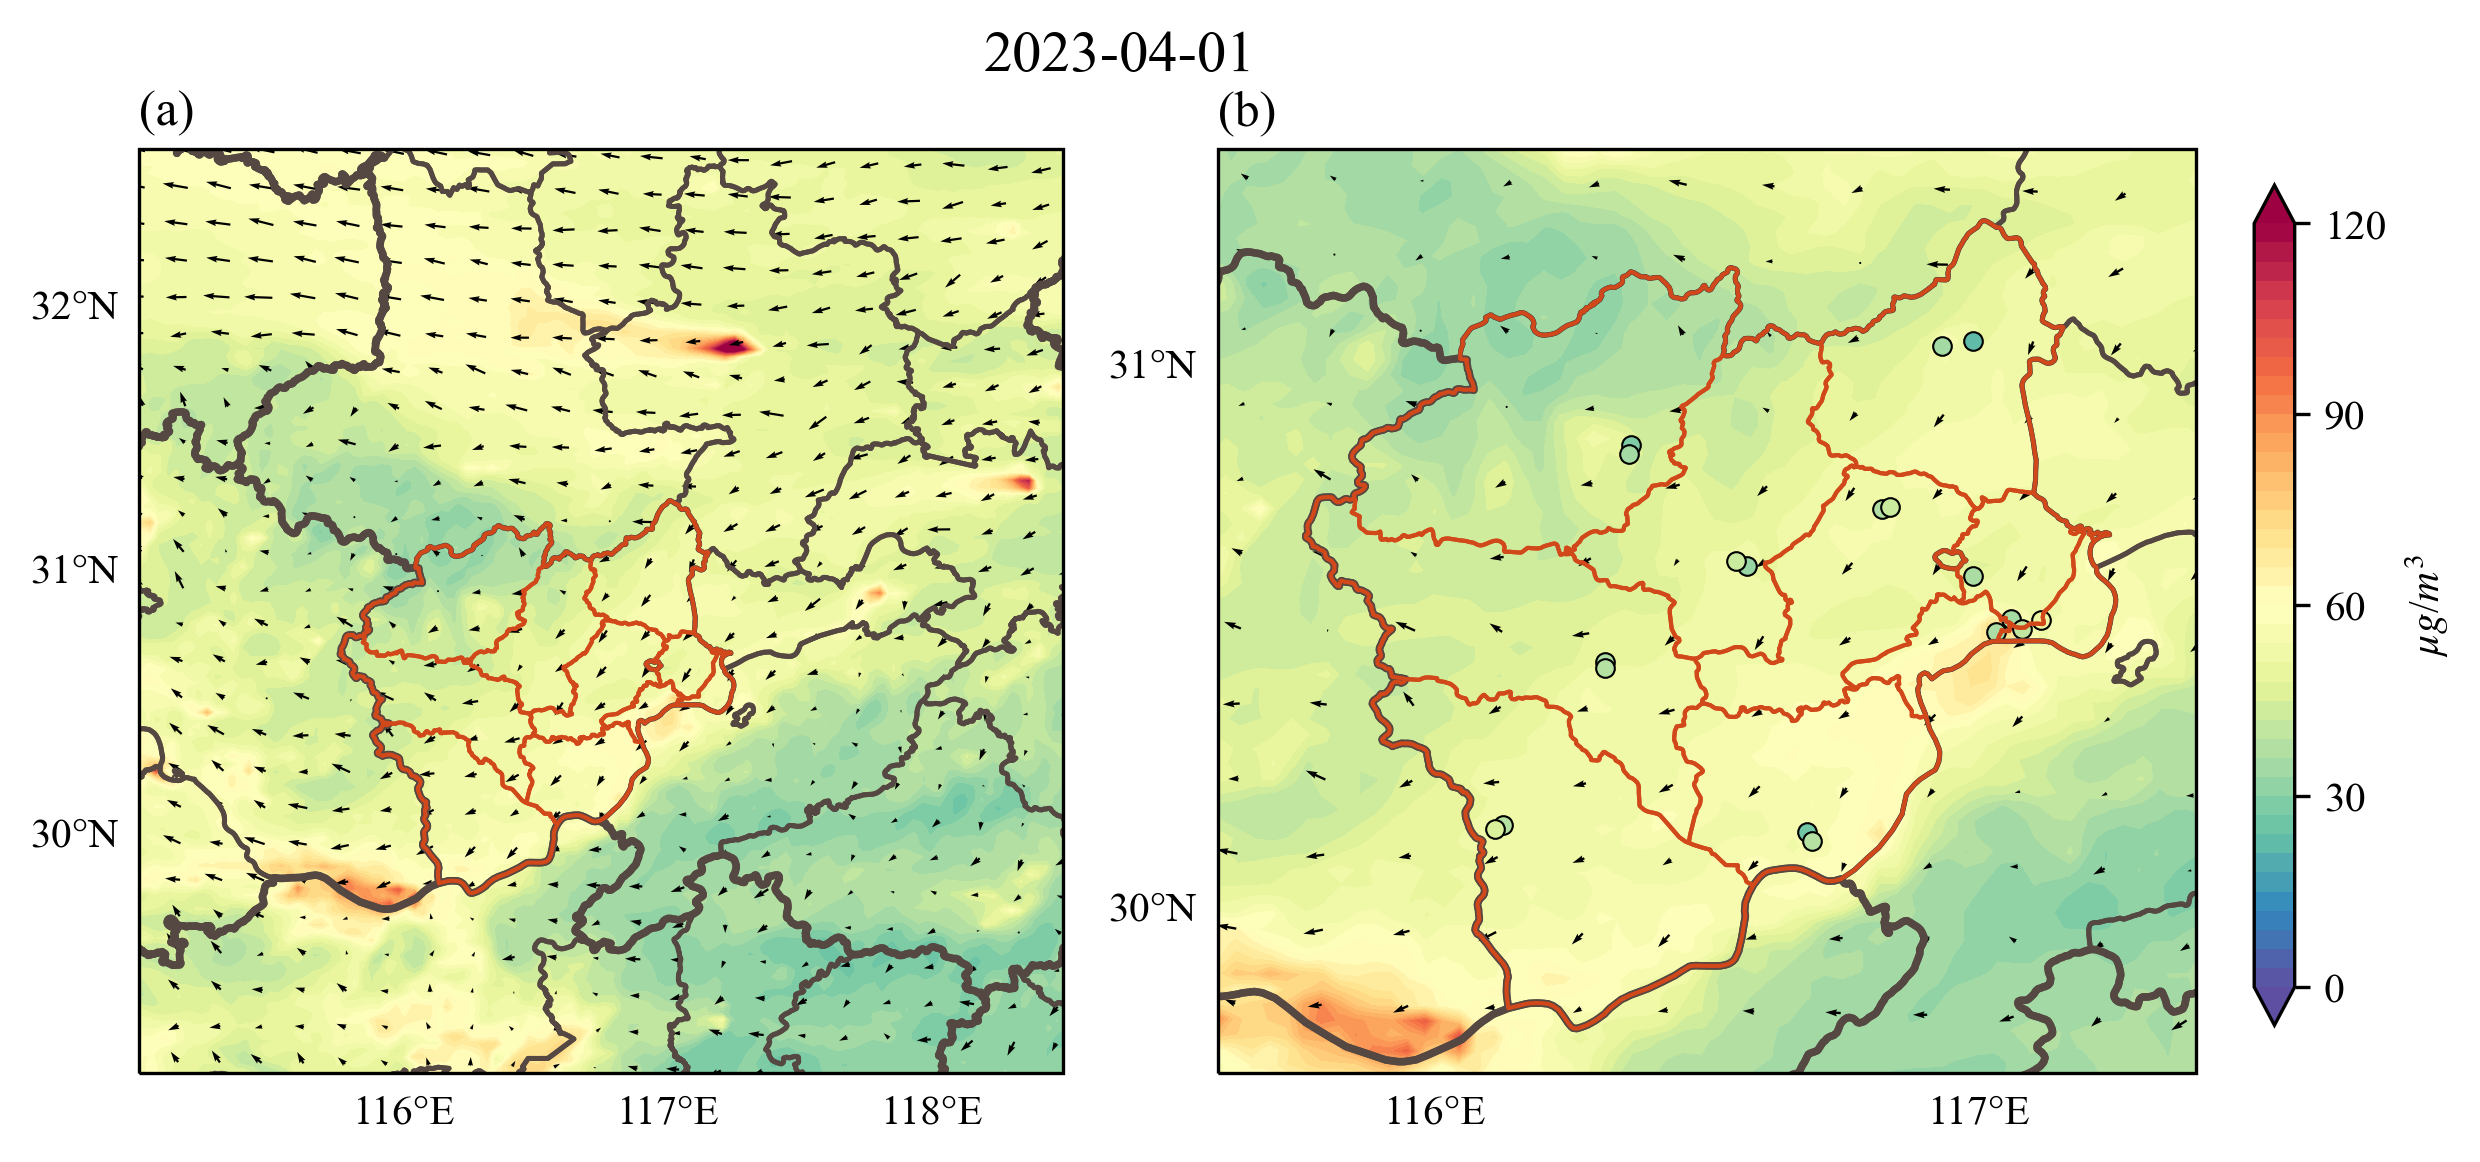

In [7]:
date=1
cmax=121
cmaplevel=np.arange(0,cmax,3)
proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
ax = fig.subplots(1,2,subplot_kw={'projection':proj})

shp_aq = Reader('F:/Data/case_anqing/shapefile/Anqing_district/anqing_district.shp')
shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
shp_cit = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/3. City/city.shp')
for i in range(2):
    ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.8)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_cit.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.2)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_aq.geometries(),proj,edgecolor='#d1481a',facecolor='None'), linewidth=1)

    gl=ax[i].gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels =False
    gl.rotate_labels=False


ax[0].set_extent([115., 118.5, 29.1, 32.6],ccrs.PlateCarree()) # d03
ax[1].set_extent([115.6, 117.4, 29.7, 31.4],ccrs.PlateCarree()) # anqing

xgrid=np.size(uuL1,2)
ygrid=np.size(vvL1,1)
ngrid=5 # 8 for d03

# contour map
cmap=ax[0].contourf(lon,lat,avg_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')
cmap=ax[1].contourf(lon,lat,avg_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')

# wind quiver
ax[0].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
        transform=proj,color='k',alpha=1,scale=150,headwidth=3)
ax[1].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
        transform=proj,color='k',alpha=1,scale=150,headwidth=3)

# station obs
for m in range(np.size(df.columns)):
    sitename = sites['站点名称'][m]
    ax[1].scatter(sites['经度'][m],sites['纬度'][m],transform=proj,marker='o',s=20,
                  c=avg_obs[sitename][date-1],cmap='Spectral_r',vmin=0,vmax=cmax,edgecolors='k',linewidth=0.5)

# share colorbar
fig.subplots_adjust(right=0.9,wspace=0.12)
position= fig.add_axes([0.92,0.15,0.015,0.7])
cbar=fig.colorbar(cmap,cax=position)
cbar.set_ticks(np.arange(0,cmax+1,30))
cbar.set_label('$\mu$$g$/$m^3$')

ax[0].set_title('(a)',loc='left')
ax[1].set_title('(b)',loc='left')
plt.suptitle(pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'),size=14)

plt.show()

In [ ]:
dates=np.arange(1,31)
cmax=121
cmaplevel=np.arange(0,cmax,3)
proj=ccrs.PlateCarree()

for date in dates:
    fig = plt.figure(figsize=(9,4),dpi=300)
    ax = fig.subplots(1,2,subplot_kw={'projection':proj})

    shp_aq = Reader('F:/Data/case_anqing/shapefile/Anqing_district/anqing_district.shp')
    shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
    shp_cit = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/3. City/city.shp')
    for i in range(2):
        ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.8)
        ax[i].add_feature(cfeat.ShapelyFeature(shp_cit.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.2)
        ax[i].add_feature(cfeat.ShapelyFeature(shp_aq.geometries(),proj,edgecolor='#d1481a',facecolor='None'), linewidth=1)

        gl=ax[i].gridlines(
            xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
            draw_labels=True, x_inline=False, y_inline=False,
            linewidth=0, linestyle='--', color='gray')
        gl.top_labels = False
        gl.right_labels =False
        gl.rotate_labels=False


    ax[0].set_extent([115., 118.5, 29.1, 32.6],ccrs.PlateCarree()) # d03
    ax[1].set_extent([115.6, 117.4, 29.7, 31.4],ccrs.PlateCarree()) # anqing

    xgrid=np.size(uuL1,2)
    ygrid=np.size(vvL1,1)
    ngrid=5 # 8 for d03

    # contour map
    cmap=ax[0].contourf(lon,lat,avg_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')
    cmap=ax[1].contourf(lon,lat,avg_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')

    # wind quiver
    ax[0].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
            uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
            transform=proj,color='k',alpha=1,scale=150,headwidth=3)
    ax[1].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
            uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
            transform=proj,color='k',alpha=1,scale=150,headwidth=3)

    # station obs
    for m in range(np.size(df.columns)):
        sitename = sites['站点名称'][m]
        ax[1].scatter(sites['经度'][m],sites['纬度'][m],transform=proj,marker='o',s=20,
                    c=avg_obs[sitename][date-1],cmap='Spectral_r',vmin=0,vmax=cmax,edgecolors='k',linewidth=0.5)

    # share colorbar
    fig.subplots_adjust(right=0.9,wspace=0.12)
    position= fig.add_axes([0.92,0.15,0.015,0.7])
    cbar=fig.colorbar(cmap,cax=position)
    cbar.set_ticks(np.arange(0,cmax+1,30))
    cbar.set_label('$\mu$$g$/$m^3$')

    ax[0].set_title('(a)',loc='left')
    ax[1].set_title('(b)',loc='left')
    plt.suptitle(pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'),size=14)
    plt.savefig('D:/Download/PM25_'+pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'))
    print('saving PM25 on '+pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'))

# plt.show()